In [ ]:
#default_exp transparent

In [ ]:
#hide 
%load_ext autoreload
%autoreload 2
%matplotlib notebook 

# Transparent thinking  

> No scattering makes life easier 


Simulation of color change over time requires a structural color physics model. In the general case of scattering colorants this is quite a challenge. First we need to know the optical absorption (*K*) and scattering (*S*) properties of all paints in the palette. Furthermore we need to know the distribution of all paints. Finally this stratigraphic model data then needs to be fed into the complicated mathematical machinery of Kubelka-Munk equations. 

Pff, all together a rather complicated problem. We will deal with this later. Fortunately, the modeling of transparent (i.e. non-scattering) colors such as inks and dyes is much simpler. An object can be thought of as a background with a number of transparent colored layers on top. These layers act like filters. Their ordering does not matter. Such colors are called subtractive. The colors of a color photograph are the result of the combined filter action of specific amounts of cyan, magenta and yellow. 

## Creating a stratigraphic model 

In a typical situation we are confronted with a drawing or photograph and we do not have information about the palette of inks or the set of dyes that constitute the primaries. Also we do not know how these colorants are distributed. We magically need to separate the optical properties of the colorants, and come up with a concentration or thickness map for each colorant layer. 

Let's load the `kaleidoscope()` test image, and learn how we can separate the cyan, magenta and yellow primary colors. 

In [ ]:
from inktime import kaleidoscope 

test_img = kaleidoscope()

<IPython.core.display.Javascript object>


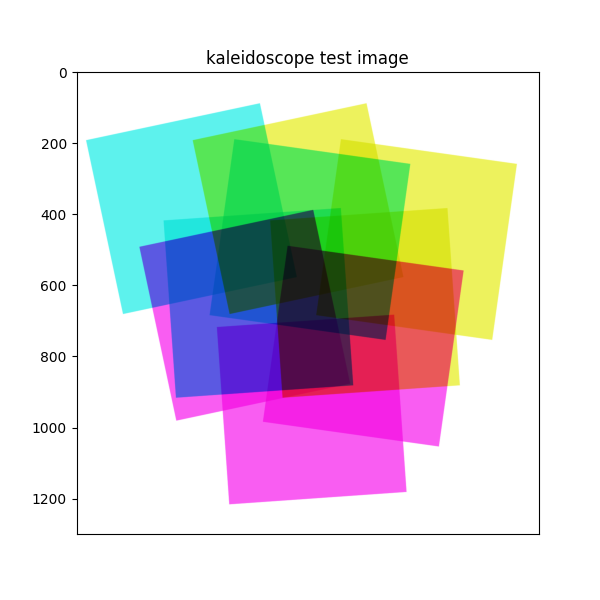

In [ ]:
#hide_input 
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(figsize=[6, 6])
ax.imshow(test_img)
ax.set_xticks([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('kaleidoscope test image');

A first step in the construction of a stratigraphic model is the detection of primary colors as the corners of the normalized optical density palette histogram. 

Returning CMY triangle nod primaries


<IPython.core.display.Javascript object>


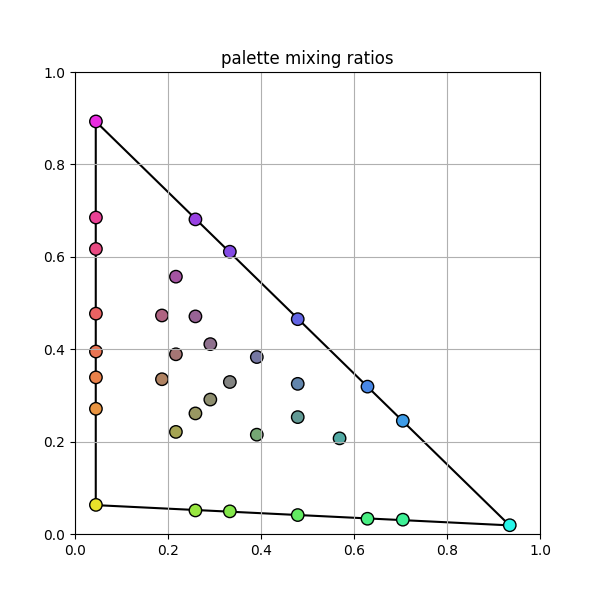

In [ ]:
from inktime import palette_histogram, primaries  

palette_histogram(test_img)

The coordinates of cyan, magenta and yellow can be computed with the `primaries()` function. 

In [ ]:
primaries(test_img)

Returning CMY triangle nod primaries


array([[0.89285714, 0.04464286],
       [0.01869159, 0.93457944],
       [0.0625    , 0.04464286]])

Now we can continue and construct a three layer stratigraphic model... 

**Coming soon!**

In [ ]:
#hide
import numpy as np 
# matrix arithmetic 

M = np.array([[1, 2, 8], [4, -1, 0], [2, 5, 7]])

x = np.array([[1], [0], [0]])

M @ x

M_inv = np.linalg.inv(M)

M @ M_inv

array([[1],
       [4],
       [2]])

In [ ]:
#export 
import numpy as np 
import matplotlib.pyplot as plt 
import skimage.transform as skt 
from scipy.spatial import ConvexHull 


def transmission(D, K):    
    '''Calculate the RGB transmission for a colored transparent layer. 
    
    Parameters:
    -----------
    
    D: array ( height x width)
        Transparent colorant thickness image
    K: tuple-like (n channels)
        Colorant absorption coefficients for RGB channels 
        
    Returns:
    --------
    
    T: transmission image (height x width)
    
    '''
    
    # convert possible list or tuple into numpy array 
    K = np.array(K)
    
    # prepare dimensions for broadcasting multiplication  
    D = D[:,:, None]    
    K = K[None, None, :]
    
    # multiply 
    optical_density = D * K 
    
    # Lambert-Beer 
    T = np.exp(-optical_density)
    
    return T


def kaleidoscope(K_CMY=None, bg_color='white', return_layers=False): 
    '''Create test 'kaleidoscope' test image.
    
    For testing purposes custom primaries matrix *K_CMY* and background color *bg_color* 
    can be chosen. 
    
    If *return_layers*=True, then addition layer primaries and transmission images are returned.   
    '''
    
    # create foil stacks 
    
    foil_0 = np.zeros([1000, 1000])
    foil_0[100:600, 100:600] = 1
    foil_0 = skt.rotate(foil_0, 12)

    foil_1 = np.zeros([1000, 1000])
    foil_1[200:700, 400:900] = 1 
    foil_1 =  skt.rotate(foil_1, -8)

    foil_2 = np.zeros([1000, 1000])
    foil_2[400:900, 250:750] = 1 
    foil_2 =  skt.rotate(foil_2, 4)

    foil_stack = foil_0 + foil_1 + foil_2 
    
    # canvas 
    bg = np.zeros([1300, 1300])

    left_stack = bg.copy()
    left_stack[0:1000, 0:1000] = foil_stack 

    middle_stack = bg.copy()
    middle_stack[300:1300, 150:1150] = foil_stack 

    right_stack = bg.copy()
    right_stack[0:1000, 300:1300] = foil_stack 
    
    # colorize foil stacks 
    
    if K_CMY is None: 
        # default primaries 
        K_CMY = [[1, 0.05, 0.07], [0.02, 1, 0.05], [0.07, 0.05, 1]]
        
    K_cyan, K_magenta, K_yellow = K_CMY 

    T_cyan = transmission(left_stack, K_cyan)
    T_magenta = transmission(middle_stack, K_magenta)
    T_yellow = transmission(right_stack, K_yellow) 
    
    # create background    
  
    if bg_color is 'white': 
        bg_color = np.array([1, 1, 1])    
    elif bg_color is 'yellowish':  
        bg_color = np.array([0.92, 0.9, 0.85])    
    else: 
        bg_color = np.array(bg_color)

    Rg = np.ones([1300, 1300, 3]) * bg_color  
    
    # compose kaleidoscope image *R* by multiplying transmissions 
    
    RGB_img = Rg * T_cyan * T_magenta * T_yellow 
    
    if return_layers is False: 
        
        return RGB_img
    
    else: 
        
        return K_CMY, [Rg, T_cyan, T_magenta, T_yellow], RGB_img

            
def optical_density(rgb_img, normalize=True, thresh=0): 
    '''Create normalized optical density image from input *rgb_img*. 
    '''
        
    # create optical density image 
    od_img = -np.log(rgb_img)

    if normalize: 

        # separate channels to making coding easier 
        od_r, od_g, od_b = od_img.transpose(2, 0, 1)

        # compute normalization 
        norm = od_r + od_g + od_b 

        # normalize only non zero (above threshold) od channels 
        is_ink = norm > thresh

        od_r_norm = od_r.copy()
        od_r_norm[is_ink] = od_r[is_ink] / norm[is_ink]

        od_g_norm = od_g.copy()
        od_g_norm[is_ink] = od_g[is_ink] / norm[is_ink]

        od_b_norm = od_b.copy()
        od_b_norm[is_ink] = od_b[is_ink] / norm[is_ink]

        # recombine channels  
        od_img = np.dstack([od_r_norm, od_g_norm, od_b_norm]) 

    return od_img  



def primaries(rgb_img, method='nearest', thresh=0, verbose=True): 
    '''Find colorant normalized optical density nod_primaries from input *rgb_img*. 
    '''
    # get ink pixel nods from image 
    
    nod_xy = _get_nod_xy(rgb_img, thresh=thresh)
    nod_x, nod_y = nod_xy.T 
    
    # locate primaries 
    
    if method is 'nearest': 
        if verbose: 
            print('Returning CMY triangle nod primaries')
        cyan_i = np.argmin((nod_x - 1)**2 + (nod_y - 0)**2)
        magenta_i = np.argmin((nod_x - 0)**2 + (nod_y - 1)**2)
        yellow_i = np.argmin((nod_x - 0)**2 + (nod_y - 0)**2) 
        
        nod_primaries = np.array([nod_xy[cyan_i], nod_xy[magenta_i], nod_xy[yellow_i]])
        
    if method is 'convex': 
        if verbose: 
            print('Returning convex hull vertices nod primaries (arbitrary order)')
        hull = ConvexHull(nod_xy)
        nod_primaries = nod_xy[hull.vertices][0:-1]

    return nod_primaries 


def _get_nod_xy(rgb_img, thresh=0): 
    '''Convert ink pixels in *rgb_img* into normalized optical density tuple list. '''
    
    nod_img = optical_density(rgb_img, normalize=True, thresh=thresh)  
    norm = np.sum(nod_img, axis=2) 
    is_ink = norm > thresh 
    
    nod_xyz = nod_img[is_ink]
    nod_xy = nod_xyz[:, 0:2]
    
    return nod_xy


def palette_histogram(rgb_img): 

    bins = 500 
    step = 1 / bins 
    blob_npix = 100 

    # convert rgb image into non-zero nod tuple list 
    nod_xy = _get_nod_xy(rgb_img)
    nod_x, nod_y = nod_xy.T 

    # compute histogram 
    counts = np.histogram2d(nod_x, nod_y, bins=bins, range=[[0, 1], [0, 1]])[0] 

    # create CMY color triangle 
    centroids = np.arange(0, 1, step) + step/2

    xx, yy = np.meshgrid(centroids, centroids)
    zz = 1 - xx - yy  
    zz[zz < 0] = 0

    is_out = xx + yy > 1 
    xx[is_out] = 0
    yy[is_out] = 0 
    zz[is_out] = 0 

    xyz_triangle = np.dstack([xx, yy, zz]) 
    rgb_triangle = np.exp(-2*xyz_triangle)

    is_significant = counts > blob_npix

    blob_x = xx[is_significant]
    blob_y= yy[is_significant]
    blob_rgb = rgb_triangle[is_significant]
    
    # draw primaries triangle 
    nod_primaries = primaries(rgb_img)
    nod_primaries = np.r_[nod_primaries, nod_primaries[[0]]] # close polygon 
    nod_y, nod_x = nod_primaries.T

    fig, ax = plt.subplots(figsize=[6, 6])
    ax.scatter(blob_x, blob_y, edgecolor='k', facecolor=blob_rgb, s=80)
    ax.plot(nod_x, nod_y, color='k', zorder=-10)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid()
    ax.set_title('palette mixing ratios')
    
class Stratigraphy: 
    
    def __init__(self, rgb_img): 
        '''Create a transparent CMY three layer model for an rgb image'''
        
        self.rgb_img = rgb_img 
        self.nod_img = optical_density(rgb_img) 
        
        print('Work in progress...')
        
        

## Non-negative Matrix Factorization (NMF) 

Another possibility to create a colorant separation is the Non-negative Matrix Factorization algorithm. I need to experiment further to see if this a good alternative to our approach above. See: [scikit-learn.org](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html)

As a first step we need to calculate the optical density for the three channels in the RGB image by taking the negative logarithm. 

**To be continued...**

In [ ]:
#hide 
import inktime 
import numpy as np 
from sklearn.decomposition import NMF 

test_img = inktime.kaleidoscope()

od_img = -np.log(test_img)
is_negative = od_img < 0
od_img[is_negative] = 0

shape = od_img.shape

X = od_img.reshape([-1, 3])

#model = NMF(n_components=3, init='random', random_state=0, alpha_W=0.2, alpha_H=0.2, tol=0.000001, max_iter=3000)

#model = NMF(n_components=3, init='nndsvd', random_state=0, solver='cd', beta_loss='frobenius', max_iter=3000, tol=0.000001)
#NMF(n_components=3, init='nndsvda', random_state=0, solver='cd', beta_loss='frobenius', max_iter=3000, tol=0.000001)

# best before update with alpha=1
#model = NMF(n_components=3, init='nndsvd', random_state=0, alpha_W=1, alpha_H=0, solver='cd', beta_loss='frobenius', max_iter=3000, tol=0.000001)

#not very good at all 
#model = NMF(n_components=3, init='random', random_state=0, alpha_W=0.2, alpha_H=0.2, tol=0.000001, max_iter=3000)

#model = NMF(n_components=3, init='nndsvd', l1_ratio=1.0, alpha=1, random_state=0, tol=0.001, max_iter=300)

# not so good as alpha=1
#model = NMF(n_components=3, init='nndsvd', alpha_W=1, alpha_H=0, random_state=0, tol=0.001, max_iter=300)

# not so good as alpha=1
#model = NMF(n_components=3, init='nndsvd', alpha_W=0.33, alpha_H=0, random_state=0, tol=0.001, max_iter=300)

#model = NMF(n_components=3, init='nndsvd', alpha=1, random_state=0, tol=0.001, max_iter=300)

#model = NMF(n_components=3, init='nndsvd', alpha_W=1, alpha_H=0, random_state=0, tol=0.001, 
#            max_iter=3000, regularization='transformation')

W = model.fit_transform(X)
H = model.components_

W_img = W.reshape(shape)


fig, axs = plt.subplots(nrows=2, ncols=3, figsize=[9, 7])

axs[0, 0].imshow(W_img[:,:,0])
axs[0, 1].imshow(W_img[:,:,1])
axs[0, 2].imshow(W_img[:,:,2])

axs[1, 0].imshow(transmission(W_img[:,:,0], H[0]))
axs[1, 1].imshow(transmission(W_img[:,:,1], H[1]))
axs[1, 2].imshow(transmission(W_img[:,:,2], H[2]))

test_img_fit = inktime.transmission(W_img[:,:,0], H[0]) * transmission(W_img[:,:,1], H[1]) * transmission(W_img[:,:,2], H[2])

fig, [ax, ax1] = plt.subplots(ncols=2, figsize=[9, 5])

ax.imshow(test_img)
ax.set_title('original')
ax1.imshow(test_img_fit)
ax1.set_title('factorisation');